### Reconstruct a subset of the Upgrade test events

In [1]:
import pickle
import math
import time
import os
from multiprocessing import Process, Pool
from copy import deepcopy
from functools import partial

from matplotlib import pyplot as plt
import numpy as np
import zmq

from freedom.llh_service.llh_client import LLHClient
from freedom.llh_service.service_utils import kill_service
from freedom.reco import crs_reco, summary_df, transforms

In [2]:
params = {'legend.fontsize': 17,
          'figure.figsize': (15, 9.3),
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

In [3]:
cvmfs_path = '/cvmfs/icecube.opensciencegrid.org/users/peller/freeDOM/resources'
model_path = f'{cvmfs_path}/Upgrade_NNs'

In [4]:
n_gpus = 4

In [5]:
n_live_points = 97

In [6]:
n_events = 3200

In [7]:
with open(f'{cvmfs_path}/test_events_upgrade.pkl', 'rb') as f:
    events = pickle.load(f)[:n_events]

In [8]:
for event in events:
    event['hit_data'] = [event['hits_DOM'], event['hits_mDOM'], event['hits_DEgg']]
    event['evt_data'] = [event['total_charge_DOM'], event['total_charge_mDOM'], event['total_charge_DEgg']]

In [9]:
base_conf = {
        "poll_timeout": 1,
        "flush_period": 1,
        "n_hypo_params": 8,
        "n_hit_features": 10,
        "n_evt_features": 2,
        "send_hwm": 10000,
        "recv_hwm": 10000,
        "batch_size": {"n_hypos": 200},
        "req_addr": "tcp://127.0.0.1:*",
}

In [10]:
def start_upgrade_service(base_conf, index, obs_per_hypo, hitnet_file, chargenet_file, cuda_device=0):
    conf = deepcopy(base_conf)
    conf["batch_size"]["n_observations"] = conf["batch_size"]["n_hypos"] * obs_per_hypo
    conf["ctrl_addr"] = crs_reco.adjust_addr_string(conf["ctrl_addr"], index)
    conf["hitnet_file"] = hitnet_file
    conf["chargenet_file"] = chargenet_file
    proc = Process(target=crs_reco.start_service, 
                   args=(conf, conf["ctrl_addr"], conf["req_addr"], cuda_device))
    proc.start()
    
    return proc, conf["ctrl_addr"]

### Start the LLH services, one per module type per GPU

In [11]:
module_names = ["DOM", "mDOM", "DEgg"]
obs_per_hypo = [16, 64, 32]
hitnet_files = [f"{model_path}/hitNet_{mname}s.hdf5" for mname in module_names]
chargenet_files = [f"{model_path}/chargeNet_{mname}s.hdf5" for mname in module_names]

In [12]:
%%capture
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
ctrl_addrs = []
procs = []
for gpu_ind in range(n_gpus):
    gpu_base_conf = deepcopy(base_conf)
    gpu_base_conf["ctrl_addr"] = f"tcp://127.0.0.1:123{gpu_ind}0"
    gpu_addrs = []
    gpu_procs = []
    for i, (hitnet, chargenet, obs_fac) in enumerate(zip(hitnet_files, chargenet_files, obs_per_hypo)):
        proc, ctrl_addr = start_upgrade_service(gpu_base_conf, i, obs_fac, hitnet, chargenet, gpu_ind)
        gpu_addrs.append(ctrl_addr)
        gpu_procs.append(proc)
    
    ctrl_addrs.append(gpu_addrs)
    procs.append(gpu_procs)

### Fit a single event

In [13]:
%%time
test_out = crs_reco.fit_events(events[:1], 0, ctrl_addrs, 
                               n_live_points=n_live_points, batch_size=12, 
                               spherical_indices=[[4,5]], do_postfit=True)

CPU times: user 842 ms, sys: 126 ms, total: 968 ms
Wall time: 56.5 s


In [14]:
print(f'best fit -LLH: {test_out[0][0]["fun"]:.2f}')
print(f'true params -LLH: {test_out[0][1]:.2f}')
print('---')
print(f'n LLH calls: {test_out[0][0]["n_calls"]}')
print(f'n optimizer iterations: {test_out[0][0]["nit"]}')

best fit -LLH: -548.18
true params -LLH: -462.38
---
n LLH calls: 8617
n optimizer iterations: 439


### Fit all the events across `n_gpus` gpus

In [15]:
events_to_process = len(events)
pool_size = 50 * n_gpus
evts_per_proc = int(math.ceil(events_to_process/pool_size))
evt_splits = [events[i*evts_per_proc:(i+1)*evts_per_proc] for i in range(pool_size)]

In [16]:
gpu_inds = np.arange(pool_size) % n_gpus

In [17]:
fit_events_partial = partial(
    crs_reco.fit_events,
    ctrl_addrs=ctrl_addrs,
    n_live_points=n_live_points,
    spherical_indices=[[4,5]],
    batch_size=12,
    do_postfit=True
)

In [18]:
%%time
start = time.time()
# reconstruct with a worker pool; one LLH client per worker
with Pool(pool_size) as p:
    outs = p.starmap(fit_events_partial, zip(evt_splits, gpu_inds))
delta = time.time() - start

CPU times: user 542 ms, sys: 1.14 s, total: 1.68 s
Wall time: 19min 35s


In [19]:
all_outs = sum((out for out in outs), [])

In [20]:
total_calls = sum(out[0]['n_calls'] for out in all_outs)
total_iters = sum(out[0]['nit'] for out in all_outs)
print(f'{total_calls} total calls')
time_per_call = delta/total_calls
print(f'{total_iters} total iters')
time_per_iter = delta/total_iters
print(f'{total_calls/len(all_outs):.1f} calls per event')
print(f'{time_per_call*1e6:.2f} us per call')

print(f'{total_iters/len(all_outs):.1f} iters per event')
print(f'{time_per_iter*1e6:.2f} us per iter')

16505374 total calls
845506 total iters
5157.9 calls per event
71.24 us per call
264.2 iters per event
1390.62 us per iter


### Kill all the services

In [21]:
for addr in sum(ctrl_addrs, []):        
    kill_service(addr)
    
for proc in sum(procs, []):
    proc.join()

In [22]:
par_names = transforms.DEFAULT_LABELS
df = summary_df.build_summary_df(all_outs, par_names)

In [23]:
free_f_better = df[df.free_fit_llh < df.true_p_llh]
frac = len(free_f_better) / len(df)
print(f'free fit better frac: {frac:.2f}')

free fit better frac: 0.97


In [24]:
df.to_pickle('./test_out_ICU.pkl')

Text(0, 0.5, 'n events')

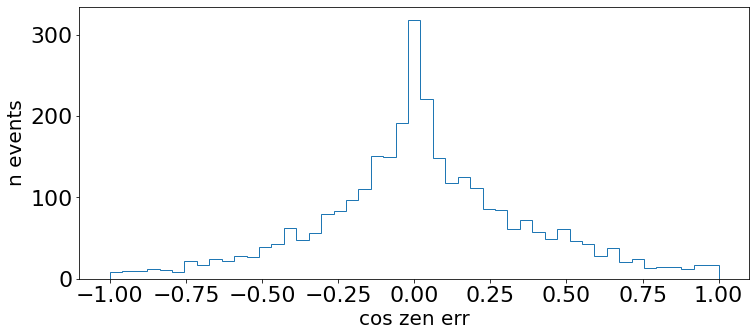

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
zen_ind = par_names.index('zenith')
true_zen = np.array([event['params'][zen_ind] for event in events])
czen_bins = np.linspace(-1, 1, 50)
ax.hist(np.cos(df.zenith) - np.cos(true_zen), bins=czen_bins, histtype='step')
ax.set_xlabel('cos zen err')
ax.set_ylabel('n events')

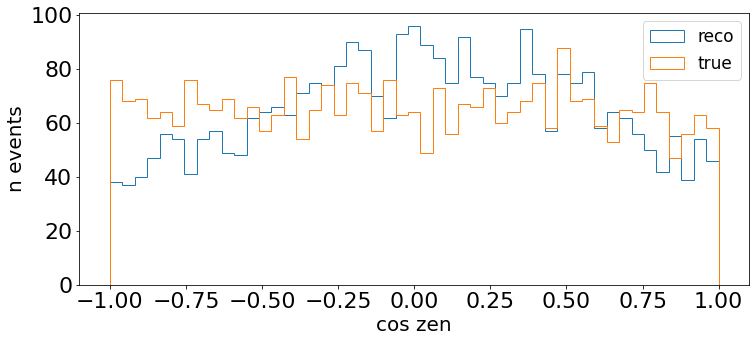

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
true_zen = np.array([event['params'][zen_ind] for event in events])
bins = np.linspace(-1, 1, 50)
ax.hist(np.cos(df.zenith), bins=bins, histtype='step', label='reco')
ax.hist(np.cos(true_zen), bins=bins, histtype='step', label='true')
ax.set_xlabel('cos zen')
ax.set_ylabel('n events')
ax.legend()